# Imports

In [1]:
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
from os import makedirs, path, listdir, remove
import httplib2
from bs4 import BeautifulSoup, SoupStrainer
import zipfile as zpf
import geopandas as gpd
from shutil import rmtree
import matplotlib.pyplot as plt

# Set variables

In [2]:
species = "SO2"
region = "London"
start_date = "1996-01-01"
end_date = "2021-01-01"

In [3]:
# Data path
folder = path.abspath("tmp") # Choose a name for the data folder 
if not path.exists(folder):
    makedirs(folder)

# Download data

In [4]:
# Get LAQN site codes
url_sites = f"http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName={region}/Json"
               
london_sites = requests.get(url_sites)
sites_df = pd.DataFrame(london_sites.json()['Sites']['Site'])
site_codes = sites_df["@SiteCode"].tolist()
print(len(site_codes))

sites_df.to_csv('site_metadata.csv')

252


In [5]:
sites_df

,@LocalAuthorityCode,@LocalAuthorityName,@SiteCode,@SiteName,@SiteType,@DateClosed,@DateOpened,@Latitude,@Longitude,@LatitudeWGS84,@LongitudeWGS84,@DisplayOffsetX,@DisplayOffsetY,@DataOwner,@DataManager,@SiteLink
0,27,Richmond,TD0,"- National Physical Laboratory, Teddington",Suburban,2018-01-01 00:00:00,1996-08-08 00:00:00,51.4243043441456,-0.345714576446947,6696103.27675,-37808.8858115,0,-200,Richmond,King's College London,http://www.londonair.org.uk/london/asp/publicd...
1,1,Barking and Dagenham,BG3,Barking and Dagenham - North Street,Kerbside,2011-05-25 00:00:00,2007-03-16 00:00:00,51.540444,0.074418,6717454.5833,8284.17386585,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...
2,1,Barking and Dagenham,BG1,Barking and Dagenham - Rush Green,Suburban,,1999-11-02 00:00:00,51.563752,0.177891,6721627.34498,19802.7355367,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...
3,1,Barking and Dagenham,BG2,Barking and Dagenham - Scrattons Farm,Suburban,,1999-10-17 00:00:00,51.529389,0.132857,6715476.18683,14789.5735883,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...
4,2,Barnet,BN2,Barnet - Finchley,Urban Background,2012-04-20 00:00:00,2000-08-09 13:00:00,51.591901,-0.205992,6726669.62886,-22930.9245475,0,0,Barnet,King's College London,http://www.londonair.org.uk/london/asp/publicd...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,33,Westminster,WMB,Westminster - Oxford Street East,Roadside,,2018-06-05 00:00:00,51.516066,-0.13516388,6712710.23315,-17008.8057704,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...
248,33,Westminster,NB1,Westminster - Strand (Northbank BID),Roadside,,2015-04-28 00:00:00,51.5119701188277,-0.116713103528546,6712364.87549212,-12992.6543679369,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...
249,33,Westminster,WM8,Westminster - Victoria,Urban Background,2016-04-04 00:00:00,2014-01-06 00:00:00,51.497066177578,-0.142438820740121,6709694.46727186,-15856.2169939846,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...
250,33,Westminster,WM9,Westminster - Victoria (Victoria BID),Roadside,2017-09-20 00:00:00,2016-08-08 00:00:00,51.4977331829735,-0.14424140916201,6709818.70995547,-16057.0573104942,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...


In [7]:
sites_df[sites_df['@SiteCode'] == 'BP0']

,@LocalAuthorityCode,@LocalAuthorityName,@SiteCode,@SiteName,@SiteType,@DateClosed,@DateOpened,@Latitude,@Longitude,@LatitudeWGS84,@LongitudeWGS84,@DisplayOffsetX,@DisplayOffsetY,@DataOwner,@DataManager,@SiteLink
234,33,Westminster,BP0,Westminster - Bridge Place,Urban Background,1999-11-21 13:45:00,1990-07-03 00:00:00,51.4938505656999,-0.143808451030166,6709119.5015,-16008.6835404,0,0,Westminster,King's College London,http://www.londonair.org.uk/london/asp/publicd...


In [6]:
# Download LAQN data

laqn_df = pd.DataFrame()

progress_bar = tqdm(site_codes)

for site_code in progress_bar:
    progress_bar.set_description(f'Working on site {site_code}')
    url_species = f"http://api.erg.kcl.ac.uk/AirQuality/Data/SiteSpecies/SiteCode={site_code}/SpeciesCode={species}/StartDate={start_date}/EndDate={end_date}/csv"
    cur_df = pd.read_csv(url_species)
    cur_df.columns = ["date", site_code]
    cur_df.set_index("date", drop=True, inplace=True)

#     try:
    if laqn_df.empty:
        laqn_df = cur_df.copy()
    else:
        laqn_df = laqn_df.join(cur_df.copy(), how="outer")

laqn_df.dropna(axis="columns", how="all", inplace=True)
laqn_df.to_csv(path.join(folder, f"LAQN_{species}_{start_date}_{end_date}.csv"))

Working on site BG1:   1%|▍                                                          | 2/251 [00:34<1:11:32, 17.24s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\kevin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\kevin\AppData\Local\Temp\ipykernel_28056\3937888956.py", line 10, in <module>
    cur_df = pd.read_csv(url_species)
  File "C:\Users\kevin\anaconda3\lib\site-packages\pandas\util\_decorators.py", line 311, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\kevin\anaconda3\lib\site-packages\pandas\io\parsers\readers.py", line 678, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "C:\Users\kevin\anaconda3\lib\site-packages\pandas\io\parsers\readers.py", line 575, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "C:\Users\kevin\anaconda3\lib\site-packages\pandas\io\parsers\readers.py", line 932, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "C:\Users\kevin\anaconda3\lib\site-packages\pandas\io\parsers\reade

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Download LAQN metadata
request = requests.get("http://api.erg.kcl.ac.uk/AirQuality/Information/MonitoringSites/GroupName=London/Json")
london_sites_df = pd.DataFrame(request.json()['Sites']['Site'])
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"]!=""]
london_sites_df = london_sites_df.loc[london_sites_df["@Latitude"].astype(float)>51]

lat = london_sites_df["@Latitude"].values
lon = london_sites_df["@Longitude"].values

# Create a geopandas dataframe
london_sites_gdf = gpd.GeoDataFrame(london_sites_df, geometry=gpd.points_from_xy(lon, lat))
london_sites_gdf.to_file(path.join(folder, "LAQN_sites.shp"))

In [ ]:
london_sites_gdf

In [7]:
# Download shape files for map plotting

# Get the web links for the borough & ward coordinate data files
web_address = "https://data.london.gov.uk/dataset/i-trees-canopy-ward-data"
status, response = httplib2.Http().request(web_address)
link_dict = {}

for link in BeautifulSoup(response, 'html.parser', parse_only=SoupStrainer('a')):
    if link.has_attr('href') and link["href"].split(".")[-1]=="zip":
        link_dict[link['href'].split("/")[-1].split(".")[0]] = f"https://data.london.gov.uk/{link['href']}"
print(f"{len(link_dict)} links found")
        
# Download the borough & ward coordinate data files and unzip them
if not path.exists(path.join(folder, "i-Trees")):
    makedirs(path.join(folder, "i-Trees"))
print("Downloading shape data...")
for url in tqdm(link_dict.values()):
    request = requests.get(url)
    filepath = path.join(folder, "i-Trees", path.basename(url))
    file = open(filepath, 'wb')
    file.write(request.content)
    file.close()
    zpf.ZipFile(filepath, 'r').extractall(path.join(folder, "i-Trees"))
    
# Compile a geopandas dataframe of the london wards coordinates
print("Compiling geopandas dataframe...")
london_wards_gdf = gpd.GeoDataFrame()

for borough in tqdm(link_dict.keys()):
    borough_folder = path.join(folder, "i-Trees", borough)
    shapefiles = [file for file in listdir(borough_folder) if file.split(".")[-1]=="shp"]
    for shapefile in shapefiles:
        gdf = gpd.read_file(path.join(borough_folder, shapefile))
        if london_wards_gdf.empty:
            london_wards_gdf = gdf
        else:
            london_wards_gdf = pd.concat([london_wards_gdf, gdf])

# Convert from ward level to boroughs
london_boroughs_gdf = london_wards_gdf.dissolve(by="BOROUGH")
london_boroughs_gdf.to_file(path.join(folder, "london_boroughs_coordinates.shp"))
rmtree(path.join(folder, "i-Trees"))

33 links found


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


Compiling geopandas dataframe...


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.81it/s]


# Load data

In [7]:
# Load LAQN data
laqn_df = pd.read_csv(path.join(folder, f"LAQN_{species}_{start_date}_{end_date}.csv"), index_col="date", infer_datetime_format=True)
print(laqn_df.shape)

(219169, 53)


(33, 10)


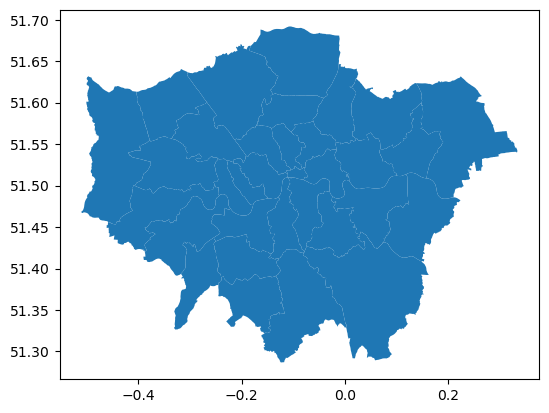

In [8]:
# Load map file
london_boroughs_gdf = gpd.read_file(path.join(folder, "london_boroughs_coordinates.shp"))
london_gdf = london_boroughs_gdf.dissolve()
print(london_boroughs_gdf.shape)
london_boroughs_gdf.plot()
plt.show()

In [9]:
# Load LAQN metadata
london_sites_gdf = gpd.read_file(path.join(folder, "LAQN_sites.shp"))
print(london_sites_gdf.shape)

(248, 17)


# Plots

In [10]:
def plot_on_map(data_geodataframe, map_geodataframe, 
                data_column=None, map_column=None, 
                data_cmap=None, map_cmap=None, 
                data_color=None, map_color="whitesmoke", 
                data_markersize=0.1, 
                map_edge_color="black", 
                colorbar=False, 
                title="Greater London", 
                fontsize="25", 
                figsize=(20,10), 
                axis="off"):
    
    data_geodataframe.plot(column=data_column, 
                           ax=map_geodataframe.plot(column=map_column, 
                                                    figsize=figsize, 
                                                    color=map_color, 
                                                    edgecolor=map_edge_color, 
                                                    cmap=map_cmap), 
                           color=data_color, cmap=data_cmap, markersize=data_markersize)
    if colorbar:
        colorbar_max = data_geodataframe[data_column].max()
        norm = plt.Normalize(data_geodataframe[data_column].min(), colorbar_max)
        plt.colorbar(plt.cm.ScalarMappable(cmap=data_cmap, 
        norm=norm)).set_label(data_column)
    
    plt.suptitle(title, fontsize=fontsize)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis(axis)
    plt.show()

## London sites

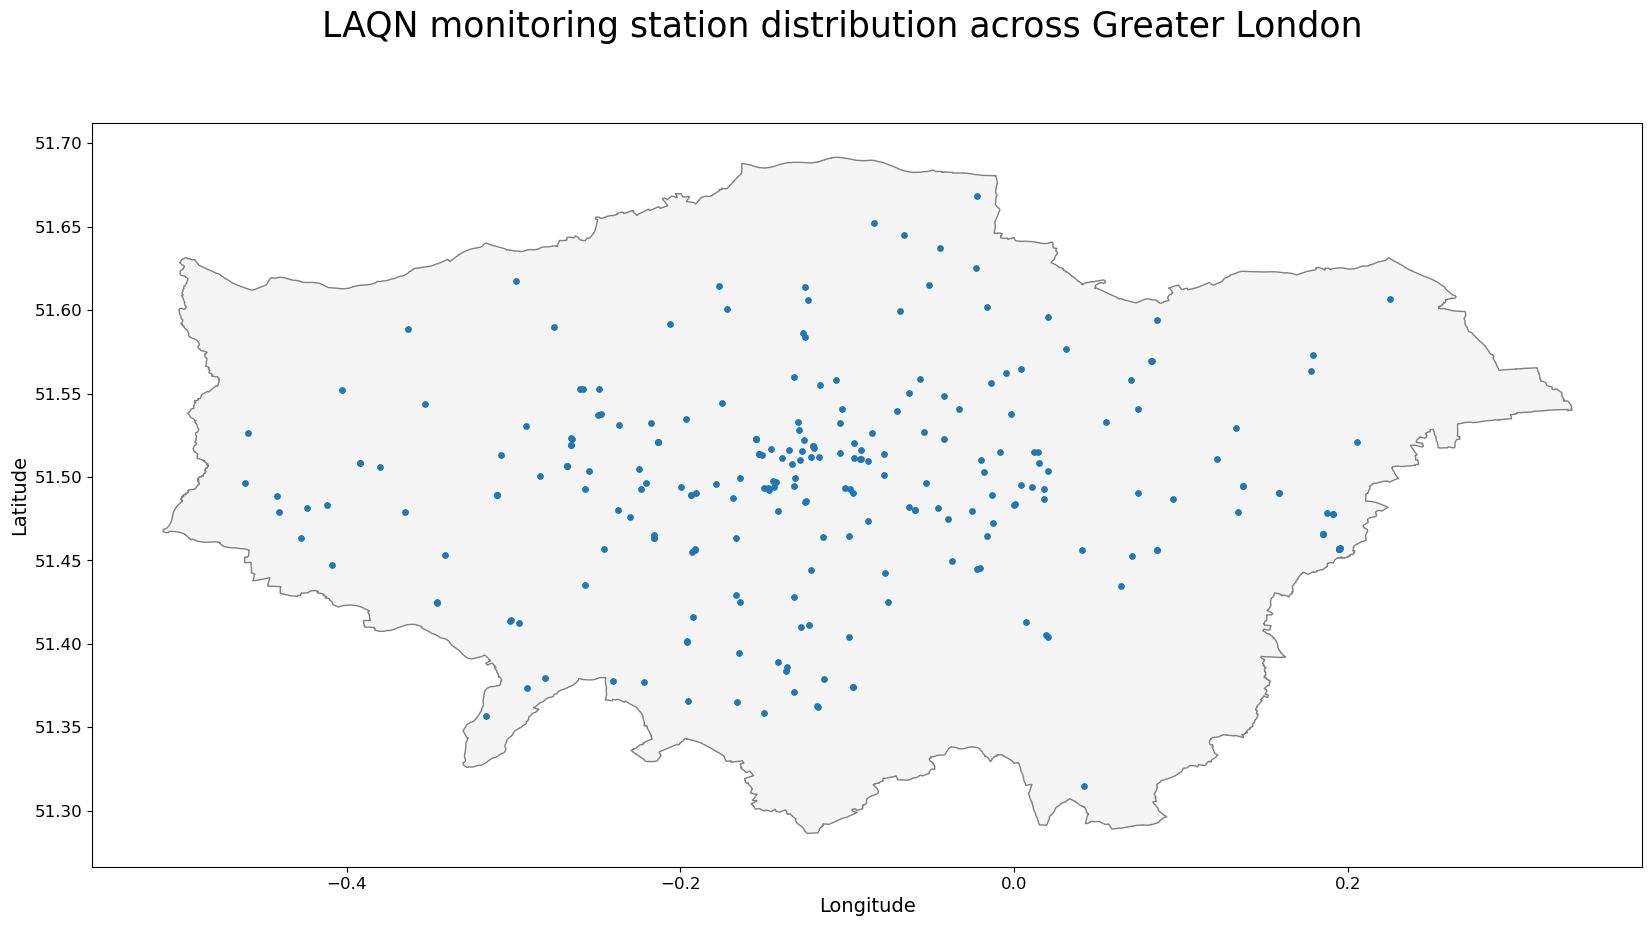

In [11]:
plot_on_map(london_sites_gdf, london_gdf, 
            title="LAQN monitoring station distribution across Greater London", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")

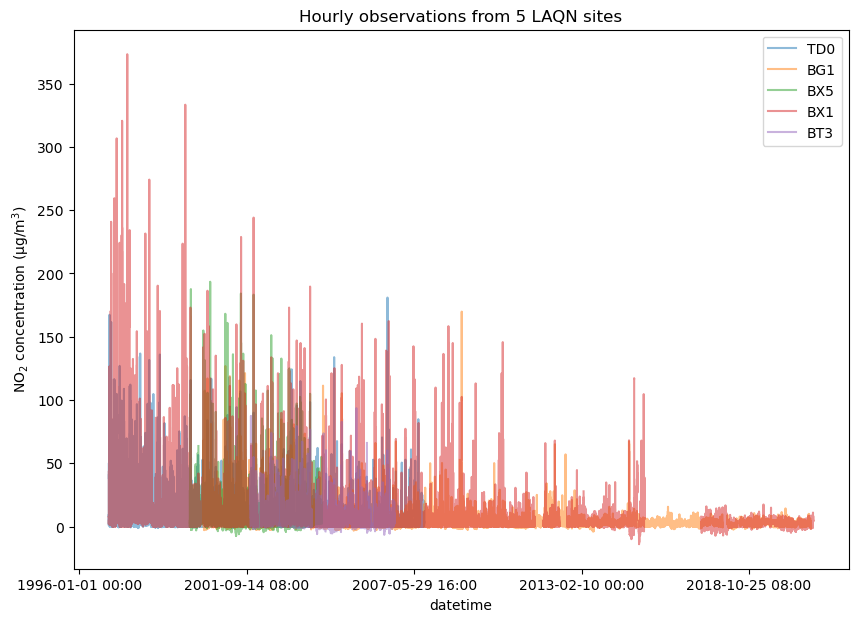

In [12]:
laqn_df[laqn_df.columns[0:5]].plot(alpha=0.5, figsize=(10,7))
plt.ylabel("NO$_2$ concentration (µg/m$^3$)")
plt.xlabel("datetime")
plt.title("Hourly observations from 5 LAQN sites")
plt.show()

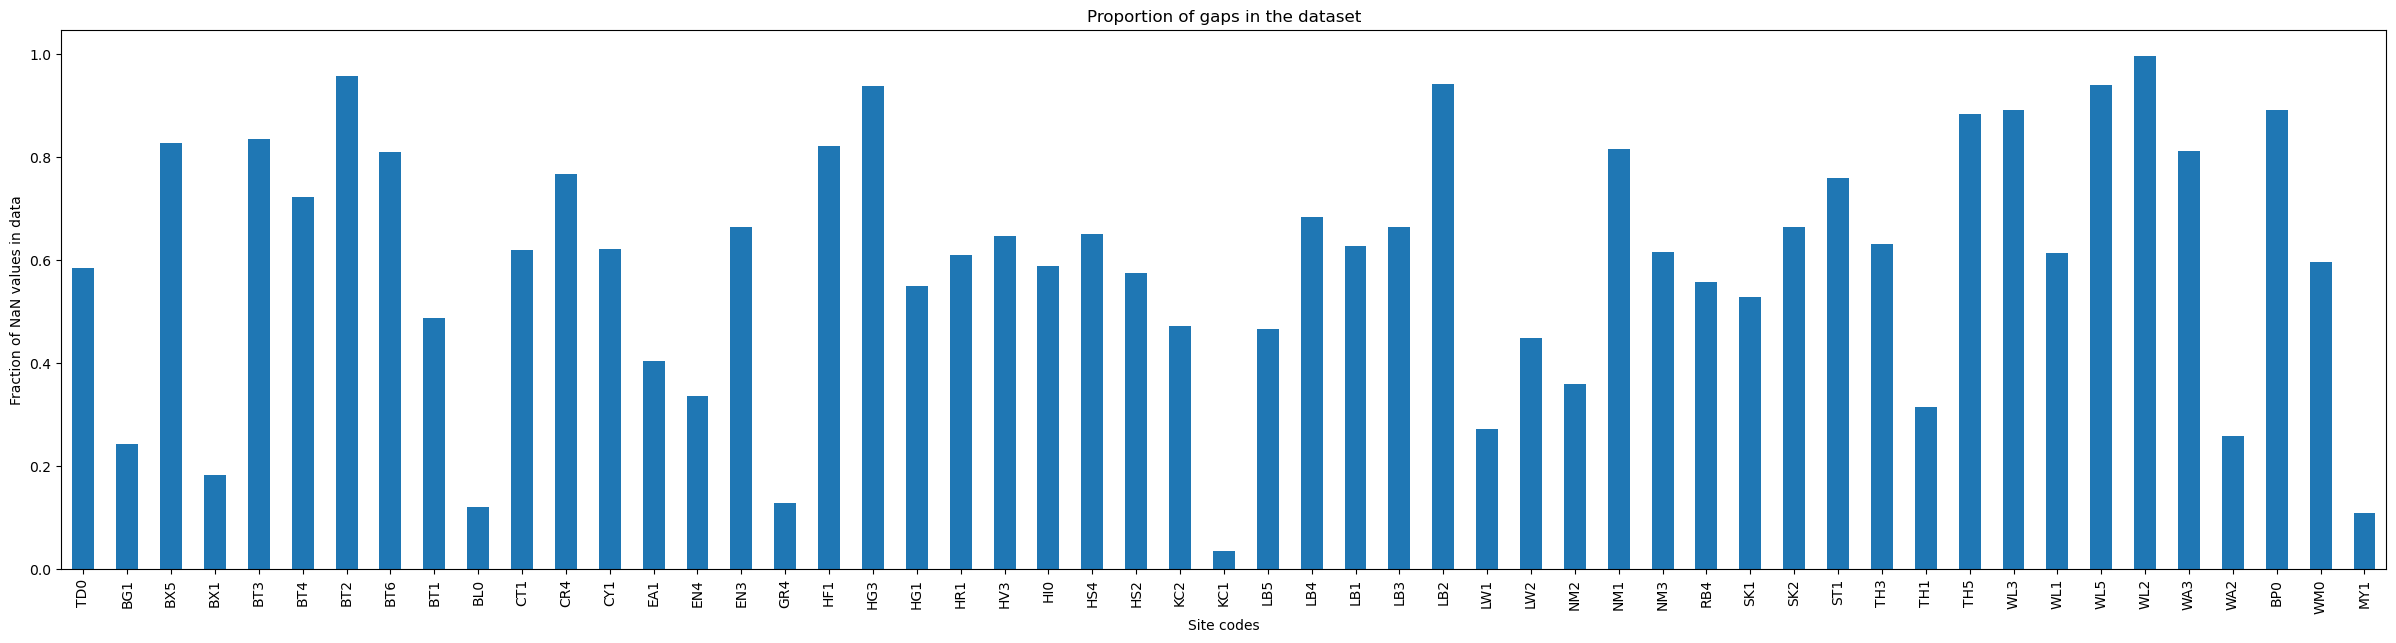

In [13]:
pd.DataFrame(laqn_df.isna().sum()/len(laqn_df)).plot.bar(figsize=(30,7), legend=False)
plt.ylabel("Fraction of NaN values in data")
plt.xlabel("Site codes")
plt.title("Proportion of gaps in the dataset")
plt.show()

In [14]:
london_sites_gdf
len(laqn_df)

219169

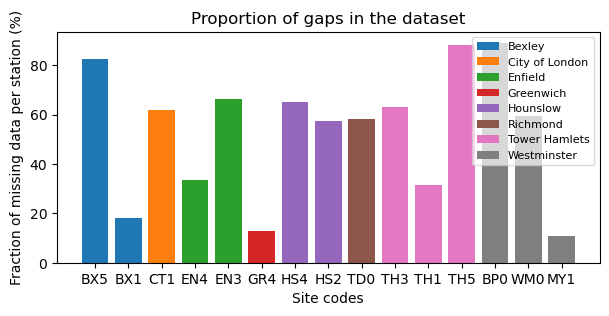

In [46]:
london_sites_gdf = pd.merge(london_sites_gdf, pd.DataFrame(laqn_df.isna().sum()/len(laqn_df), columns=["NaN fraction"]), left_on="@SiteCode", right_index=True)

fig, ax = plt.subplots(figsize=(7,3))

boroughs = ['Bexley', 'City of London', 'Enfield', 'Greenwich', 
            'Hounslow', 'Richmond', 'Tower Hamlets',  'Westminster']

# for borough in sorted(list(set(london_sites_gdf["@LocalAu_1"]))):
for borough in boroughs:
    gdf = london_sites_gdf.loc[london_sites_gdf["@LocalAu_1"]==borough]
    ax.bar(gdf["@SiteCode"], gdf["NaN fraction"].multiply(100, fill_value=0), label=borough)
# ax.legend(loc="upper right", ncol=int(np.round(len(set(london_sites_gdf["@LocalAu_1"]))/2))+1)
plt.ylabel("Fraction of missing data per station (%)")
plt.xlabel("Site codes")
plt.title("Proportion of gaps in the dataset")
plt.legend(loc=1, prop={'size': 8}, framealpha=0.7)
plt.show()

In [44]:
test= gdf["NaN fraction"].multiply(100)

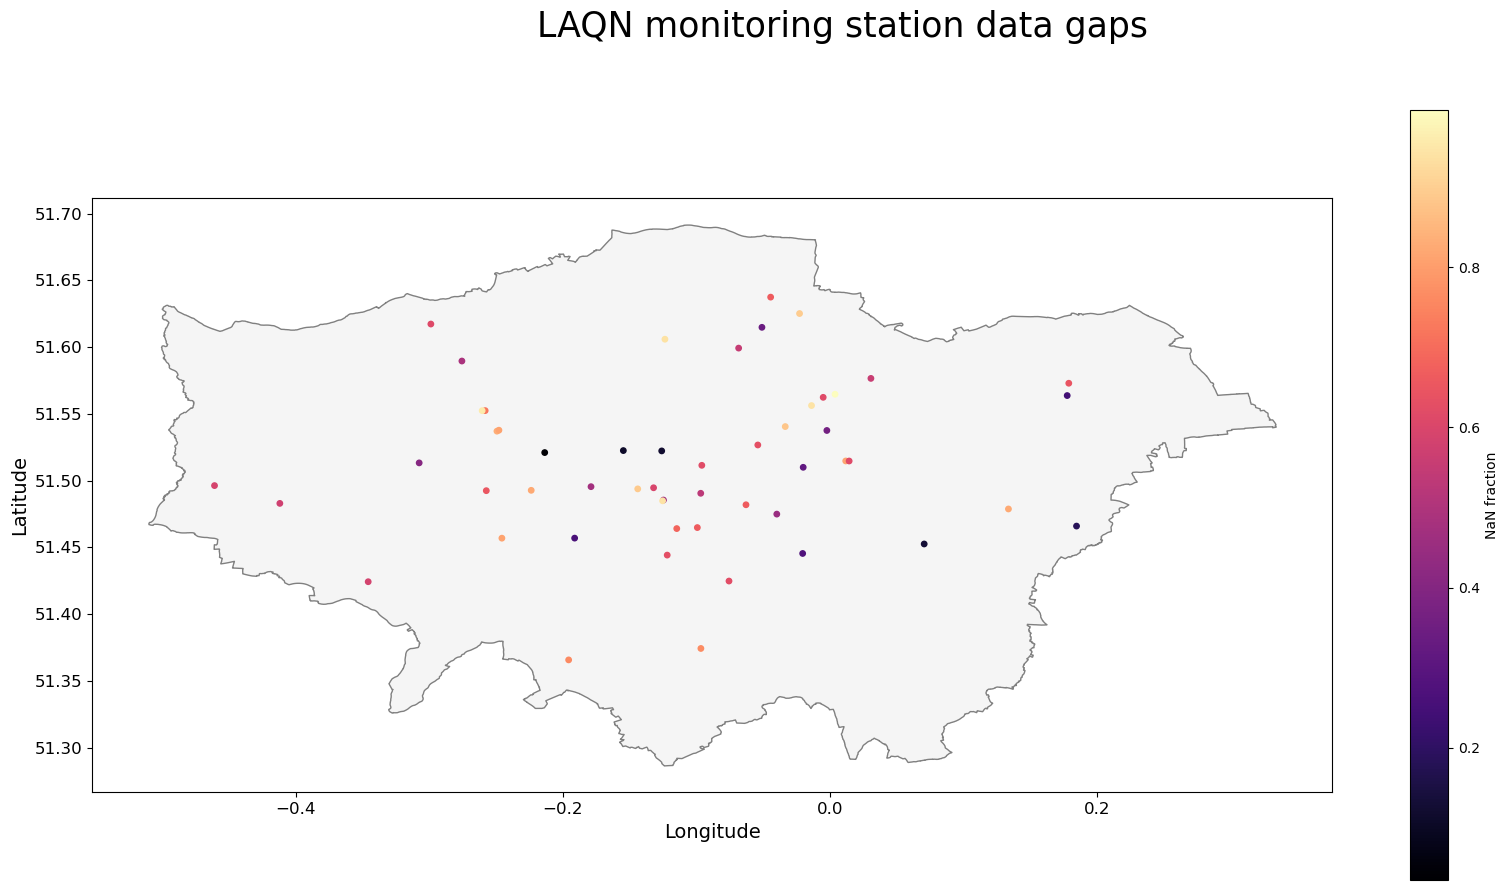

In [16]:
plot_on_map(london_sites_gdf, london_gdf, 
            data_column="NaN fraction", colorbar=True, data_cmap="magma", 
            title="LAQN monitoring station data gaps", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")

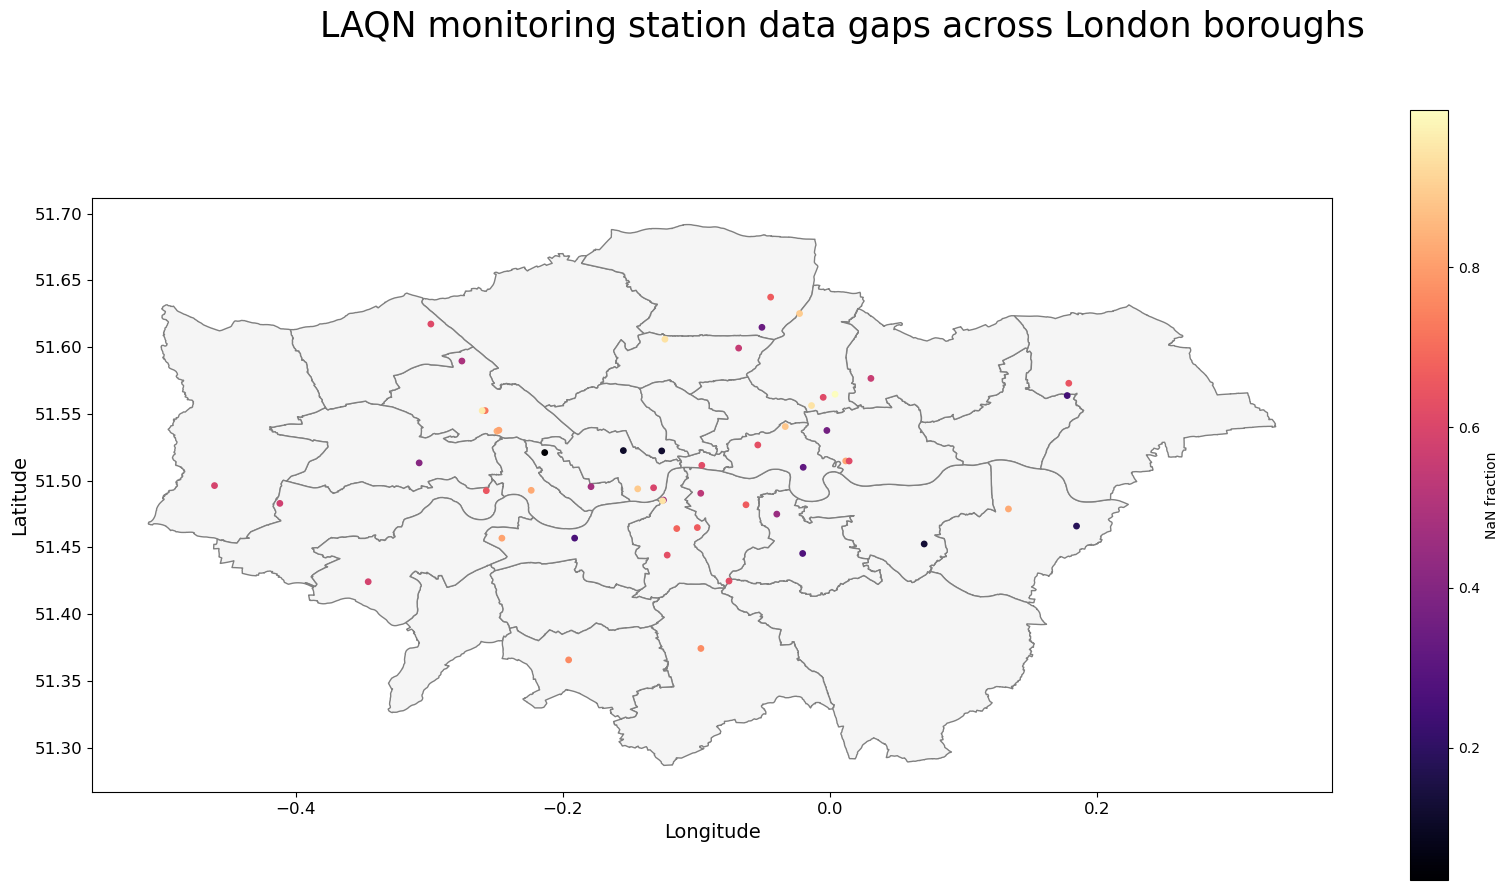

In [17]:
plot_on_map(london_sites_gdf, london_boroughs_gdf, 
            data_column="NaN fraction", colorbar=True, data_cmap="magma", 
            title="LAQN monitoring station data gaps across London boroughs", 
            data_markersize=15,  
            map_edge_color="gray", axis="on")

In [18]:
london_sites_gdf.shape

(53, 18)

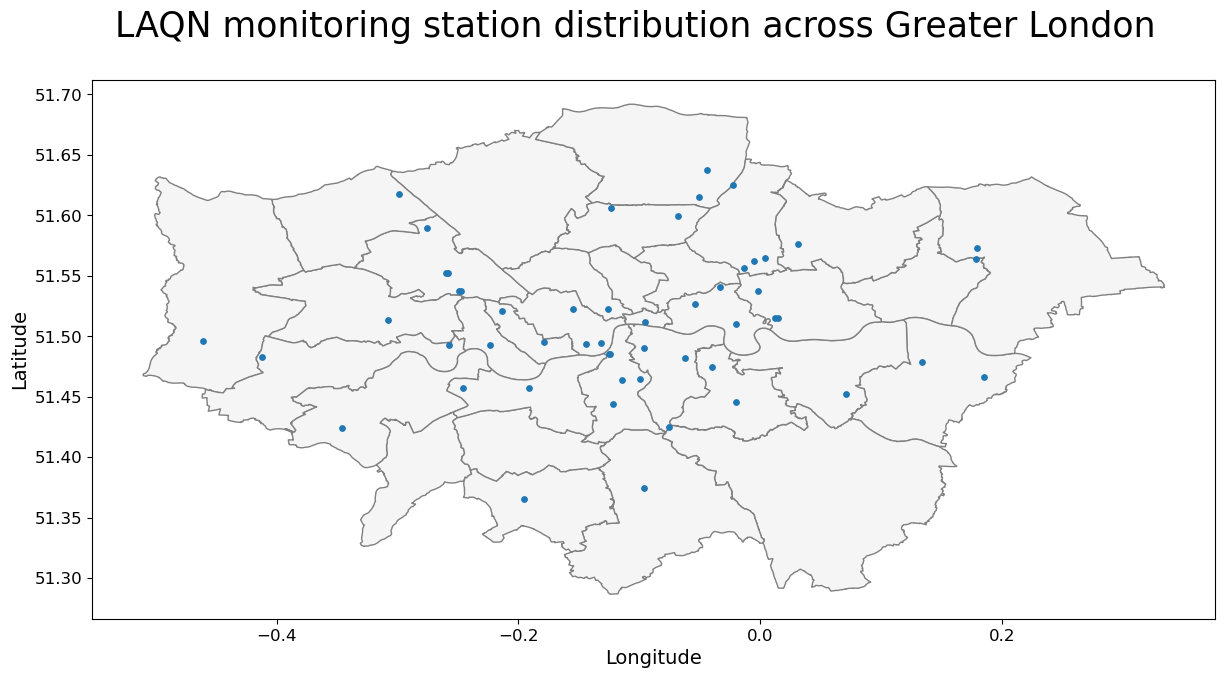

In [19]:
plot_on_map(london_sites_gdf, london_boroughs_gdf, 
            title="LAQN monitoring station distribution across Greater London", 
            data_markersize=15,  
            map_edge_color="gray", figsize=(15,7), axis="on")

In [20]:
london_sites_gdf

,@LocalAuth,@LocalAu_1,@SiteCode,@SiteName,@SiteType,@DateClose,@DateOpene,@Latitude,@Longitude,@LatitudeW,@Longitu_1,@DisplayOf,@Display_1,@DataOwner,@DataManag,@SiteLink,geometry,NaN fraction
0,27,Richmond,TD0,"- National Physical Laboratory, Teddington",Suburban,2018-01-01 00:00:00,1996-08-08 00:00:00,51.4243043441456,-0.345714576446947,6696103.27675,-37808.8858115,0,-200,Richmond,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.34571 51.42430),0.584061
2,1,Barking and Dagenham,BG1,Barking and Dagenham - Rush Green,Suburban,None,1999-11-02 00:00:00,51.563752,0.177891,6721627.34498,19802.7355367,0,0,Barking and Dagenham,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.17789 51.56375),0.243127
7,3,Bexley,BX5,Bexley - Bedonwell,Suburban,2004-04-08 00:00:00,1999-10-06 13:00:00,51.4788023547334,0.133873839062683,6706429.353,14902.767595,0,0,Bexley,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.13387 51.47880),0.827247
15,3,Bexley,BX1,Bexley - Slade Green,Suburban,None,1994-05-25 00:00:00,51.4659832746662,0.184877126994369,6704140.10457,20577.2727637,0,0,Bexley,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (0.18488 51.46598),0.182485
27,4,Brent,BT3,Brent - Harlesden,Roadside,2006-09-27 00:00:00,2001-10-31 00:00:00,51.5370800298103,-0.249273425299457,6716852.51826,-27748.9907726,-150,-150,Brent,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.24927 51.53708),0.834050
28,4,Brent,BT4,Brent - Ikea,Roadside,None,2003-06-20 06:00:00,51.552476,-0.258089,6719608.36938,-28730.3360593,0,0,Brent,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.25809 51.55248),0.721489
29,4,Brent,BT2,Brent - Ikea Car Park,Roadside,2003-06-16 00:00:00,2001-06-17 12:00:00,51.5524326273922,-0.260338843869077,6719600.60445,-28980.7875332,0,750,Brent,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.26034 51.55243),0.957184
30,4,Brent,BT6,Brent - John Keble Primary School,Roadside,None,2006-11-01 00:00:00,51.537799,-0.247793,6716981.19188,-27584.1905821,150,150,Brent,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.24779 51.53780),0.809873
31,4,Brent,BT1,Brent - Kingsbury,Suburban,2010-11-16 00:00:00,1996-01-26 00:00:00,51.589618,-0.275519,6726260.56244,-30670.6347839,0,0,Brent,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.27552 51.58962),0.487774
38,6,Camden,BL0,Camden - Bloomsbury,Urban Background,None,1992-01-23 00:00:00,51.522287,-0.125848,6714205.47041,-14009.3352774,0,0,Camden,King's College London,http://www.londonair.org.uk/london/asp/publicd...,POINT (-0.12585 51.52229),0.120916


In [21]:
pd.DataFrame(laqn_df.isna().sum()/len(laqn_df), columns=["NaN fraction"])

,NaN fraction
TD0,0.584061
BG1,0.243127
BX5,0.827247
BX1,0.182485
BT3,0.834050
BT4,0.721489
BT2,0.957184
BT6,0.809873
BT1,0.487774
BL0,0.120916


In [58]:
london_sites_gdf

geopandas.geodataframe.GeoDataFrame